In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import itertools

In [2]:
def f(x, thrust, target_pitch_rad, g):
    return ((g/thrust) + np.tan(target_pitch_rad)*np.cos(x) - np.sin(x))

def fprime(x, thrust, target_pitch_rad, g):
    return (-np.tan(target_pitch_rad)*np.sin(x) - np.cos(x))

In [3]:
# Set the gravity to 1 so that we can easily scale the effective thrust in rust.
# effective_thrust = thrust/g
g = 1
thrusts = np.linspace(1, 5, 10)
target_pitches_deg = np.linspace(-90, 90, 30)
target_pitches_rad = np.deg2rad(target_pitches_deg)
thrusts_grid, target_pitches_rad_grid = np.meshgrid(thrusts, target_pitches_rad)
target_pitches_deg_grid = np.rad2deg(target_pitches_rad_grid)

heading_pitches_rad = optimize.newton(f, target_pitches_rad_grid, fprime=fprime, args=(thrusts_grid, target_pitches_rad_grid, g))
heading_pitches_deg = np.rad2deg(heading_pitches_rad)

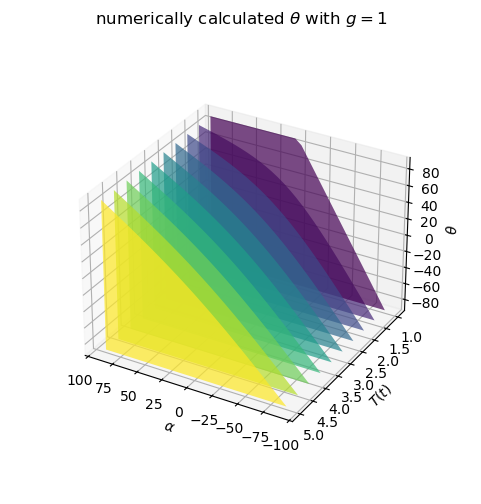

In [11]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(1, 1, 1, projection="3d")

facecolors = plt.colormaps['viridis_r'](np.linspace(1, 0, len(thrusts)))

for i, thrust in enumerate(thrusts):
    ax1.fill_between(target_pitches_deg, thrust, heading_pitches_deg.T[i],
                     target_pitches_deg, thrust, -90,
                     facecolors=facecolors[i], alpha=.7)
    # ax1.fill_between(thrusts, target_pitch, heading_pitches_deg[i],
    #                  thrusts, target_pitch, -90,
    #                  facecolors=facecolors[i], alpha=.7)

ax1.set(
    xlabel=r"$\alpha$",
    ylabel=r"$T(t)$",
    zlabel=r"$\theta$",
)
ax1.invert_xaxis()
ax1.invert_yaxis()

ax1.set_title(r"numerically calculated $\theta$ with $g=1$")
ax1.set_box_aspect(aspect=None, zoom=0.8)

In [5]:
def list_to_rust_str(l):
    list_with_commas = ", ".join([str(float(x)) for x in l])
    return f": [f64; {len(l)}] = [{list_with_commas}]"

print(f"pub static GRAVITY: f64 = {float(g)};")
print(f"pub static THRUSTS{list_to_rust_str(thrusts)};")
print(f"pub static TARGET_PITCHES{list_to_rust_str(target_pitches_deg)};")
print(f"pub static HEADING_PITCHES_LOOKUP{list_to_rust_str(heading_pitches_deg.flatten())};")

pub static GRAVITY: f64 = 1.0;
pub static THRUSTS: [f64; 10] = [1.0, 1.4444444444444444, 1.8888888888888888, 2.333333333333333, 2.7777777777777777, 3.2222222222222223, 3.6666666666666665, 4.111111111111111, 4.555555555555555, 5.0];
pub static TARGET_PITCHES: [f64; 30] = [-90.0, -83.79310344827586, -77.58620689655173, -71.37931034482759, -65.17241379310344, -58.96551724137931, -52.758620689655174, -46.55172413793103, -40.3448275862069, -34.13793103448276, -27.93103448275862, -21.724137931034477, -15.517241379310349, -9.310344827586206, -3.103448275862064, 3.103448275862064, 9.310344827586206, 15.517241379310349, 21.724137931034477, 27.93103448275862, 34.13793103448276, 40.34482758620689, 46.551724137931046, 52.758620689655174, 58.9655172413793, 65.17241379310346, 71.37931034482759, 77.58620689655172, 83.79310344827587, 90.0];
pub static HEADING_PITCHES_LOOKUP: [f64; 300] = [-90.0, -90.0, -90.0, -90.0, -90.0, -90.0, -90.0, -90.0, -90.0, -90.0, -77.58620689655172, -79.50040618796638, -80.

In [6]:
def print_test_case(g, thrust, target_pitch_deg):
    target_pitch_rad = np.deg2rad(target_pitch_deg)
    out_rad = optimize.newton(f, target_pitch_rad, fprime=fprime, args=(thrust, target_pitch_rad, g))
    out_deg = np.rad2deg(out_rad)
    print(f"    assert_relative_eq!(lookup_gravity_heading({g}, {target_pitch_deg}, {thrust}), {out_deg}, epsilon=3.0);")

for g, thrust, target_pitch_deg in itertools.product(np.linspace(0.2, 0.2, 1), np.linspace(0.2, 1, 10), np.linspace(-90, 90, 181)):
    print_test_case(g, thrust, target_pitch_deg)

    assert_relative_eq!(lookup_gravity_heading(0.2, -90.0, 0.2), -90.0, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -89.0, 0.2), -88.0, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -88.0, 0.2), -86.0, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -87.0, 0.2), -83.99999999999999, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -86.0, 0.2), -82.00000000000001, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -85.0, 0.2), -80.00000000000001, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -84.0, 0.2), -78.00000000000001, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -83.0, 0.2), -76.0, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -82.0, 0.2), -74.0, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -81.0, 0.2), -72.0, epsilon=3.0);
    assert_relative_eq!(lookup_gravity_heading(0.2, -80.0, 0.2), -70.0, epsilon=3.0);
  

In [7]:
print_test_case(0.2, 0.2, -87)

    assert_relative_eq!(lookup_gravity_heading(0.2, -87, 0.2), -83.99999999999999, epsilon=3.0);
